## setup

In [1]:
!pip install ipyfilechooser
!pip install layoutparser

In [1]:
from typing import List, Dict, Tuple, Set

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from pathlib import Path
import nltk
from ipyfilechooser import FileChooser
import ipywidgets
import layoutparser as lp
import re

import pdfplumber

In [2]:
import os
DATA = Path("scrape_out")
assert DATA.is_dir()

# processing text

In [3]:
TOK_SENTENCE_TERMS = ('.','!','?')
TOK_SENTENCE_CONTS = (',',':',';')
TERM_PUNC_STR = "".join(TOK_SENTENCE_TERMS)

def ends_with(txt, terms=('.','!','?', ':')) -> bool:
    return txt and txt.rstrip().endswith(terms)

## hyphen

- __TODO__ implement trie datastructure for more efficient searching of words; have hyphen be root node?

In [4]:
# nltk.download('wordnet')
# nltk.download('wordnet31')
from nltk.corpus import wordnet31 as wordnet

hyphen_corpus = set(filter(lambda w: "-" in w, wordnet.words()))    # select just words with hyphen
hyphen_corpus = hyphen_corpus.union({'Three-dimensional', 'Multiple-detector', 'Two-and', 'Multiple-detector', 'four-detector-row','Post-expiratory','soft-tissue','two-or','arrowhead-shaped','fat-filled','short-axis','out-flow','mirror-image','left-sided','Contrast-enhanced','post-traumatic','x-rays','medullary-based','MDCT-guided','volume-rendered','volume-rendering','contrast-opacified','thick-walled','thin-walled','bolus-contrast-enhanced','Contrast-filled','smooth-outlined','sheet-like','small-bowel','Colon-wall','tumor-involved','Early-stage','Closed-loop','B-cell','Mucosa-associated','three-layer','region-of-interest','lipid-rich','Lipid-poor', 'non-Hodgkin’s','fat-containing','bone-marrow','Thin-section','Axial-plane','sagittal-plane','well-hydrated','end-stage','image-guided','fluid-filled','non-neoplastic','hairline-thin','well-marginated','Lymphad-enectomy','Nephron-sparing','mid-T-12','CT-KUB','CT-IVP','water-density','bunch-of-grapes','main-duct','branch-duct','duct-obstructing','AIDS-related','Hormone-producing','ultrasound-guided','Long-segment','upper-quadrant','IV-A','IV-B','tech-netium-99m-labeled','technetium-99m','delayed-phase','Well-differentiated','venous-phase','arterial-phase','arterial-phase','nodule-in-nodule','False-positive','comma-shaped',})
hyphen_corpus = set(map(lambda w: w.lower(), hyphen_corpus))    # lower case

len(hyphen_corpus)

7124

In [5]:
hyphen_prefixs = {'high', 'higher', 'highest',
                  'low', 'lower', 'lowest',
                  'max', 'maximum',
                  'min', 'minimum',
                  }

hyphen_sufffixs = {'mm', 'cm', 'm'}

In [6]:
def dehyphenate_string(input_string, pg_num=None):
    out = ""
    dehyphens = []

    # remove surronding space from either left or right -- but don't conjoin
    if re.search(r"\w\s+-\s+\w", input_string):
        return input_string, dehyphens
    input_string = re.sub(r"\s*-\s*", r"-", input_string)   

    re_number       = r'^\d+(\.\d+)?-(.+)$'      # e.x. 15.25-mm
    re_word_extract = r'^(\W*)([\w’-]*)(\W*)$'
    re_hyph_split   = r'^([^-]*)-(.*)$'

    words = re.split(r'(?<=[\s+])', input_string)    # this will split, but preserve the whitespace
    for full_word in words:
        if not full_word: continue
        if "-" not in full_word or re.search(re_number, full_word):
            out += full_word
            continue
        
        try:
            match = re.search(re_word_extract, full_word)
            pre, word, post = match.groups()
            
            # assert '-' in word
            if '-' not in word:
                print(f"{word} has an assertion error!")
                continue

            match = re.search(re_hyph_split, word)
            word_pre, word_post = match.groups()
        except AttributeError:
            print(f"###{f' PG {pg_num} ::' if pg_num else ''} Failed to dehyphenate word: {full_word}")
            out += full_word
            continue
        
        if word_pre.lower() not in hyphen_prefixs and word_post.lower() not in hyphen_sufffixs:
            if word.lower() not in hyphen_corpus:
                # print('Dehyphenating word: ', word)
                dehyphens.append(word)
                word = word_pre + word_post
        out += pre + word + post
    return out, dehyphens


assert (res:=dehyphenate_string((txt:="Non-Hodgkin’s"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="max-something"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="max -something"))) == ("max-something",[]), res  # remove inner spaces
assert (res:=dehyphenate_string((txt:="max- something"))) == ("max-something",[]), res  # remove inner spaces
assert (res:=dehyphenate_string((txt:="max - something"))) == (txt,[]), res  # don't conjoin
assert (res:=dehyphenate_string((txt:="minimum-otherthing"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="highest-otherthing"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="False Positives: x-ray is a hyphenated word. 15.25-mm is a hyphenated number."))) == (txt,[]), res
assert (res:=dehyphenate_string( \
    (txt:="True Positive: This is an ex-ample of a de-hyphenated string"))) == \
    ("True Positive: This is an example of a dehyphenated string",['ex-ample', 'de-hyphenated']), res
assert (res:=dehyphenate_string((txt:=" Floats + keeps outer whitespace: Gantry rotation time is usually about 0.5 seconds. "))) == (txt,[]), res

## figures, tables, misc.

In [7]:
def process_text(text: str, log=False, pg_num=None, placeholder=None) -> str:
    placeholder = placeholder or "" 
    
    text = re.sub(r"(["+TERM_PUNC_STR+','+r"])([a-z][^\.] ?)", r"\1 \2", text, flags=re.IGNORECASE)    # e.x. abc.def -> abc. def; but not e.g. -> e. g.
    text = re.sub(r"figs?\.", "figure", text, flags=re.IGNORECASE)    # because we are splitting on '.', we need to replace 'Fig.' with 'figure'
    text = re.sub(r"(figure|table|image)s?\s+\d+\.", r"\1 ", text, flags=re.IGNORECASE)    # because we are splitting on '.', we need to replace 'figure 9.' with 'figure'
    text = re.sub(r"([\)\]\}])(\w)", r"\1 \2", text)    # e.x. (lorem)ipsum -> (lorem) ipsum
    text = re.sub(r"(\w)([\(\[\{])", r"\1 \2", text)    # e.x. lorem(ipsum) -> lorem (ipsum)
    text = re.sub(r"([a-z])([\d])", r"\1 \2", text, flags=re.IGNORECASE)    # e.x. abc1 -> abc 1
    text = re.sub(r"([a-ln-z])([A-Z])", r"\1 \2", text)    # e.x. abcDef -> abc Def; but not m* e.x. mA, mSv
    text = re.sub(r"([’']s)(\w)", r"\1 \2", text)    # e.x. 'sA -> 's A
    
    out = ""
    sentences = re.split(r'(?<=['+TERM_PUNC_STR+r'] )', text)    # this will split, but preserve the delimiter
    # print(sentences)
    for sent in sentences:
        if not sent: continue
        
        # TODO implement placeholder; give more context to downstream processing         
        ref_whole = r"([fF](igure|IGURE)|[tT](able|ABLE)|[iI](mage|MAGE))\s+[\dA-Z]"
        
        ref_parenthesis = r" ?\(.*"+ref_whole+r".*?\)"    # e.x. (lorem Table 1 ipsum) or (Fig. 2.1)
        sent = re.sub(ref_parenthesis, "", sent, flags=re.IGNORECASE)

        if re.search(ref_whole, sent):
            continue
        
        sent, dehyphs = dehyphenate_string(sent, pg_num=pg_num)
        if dehyphs and log: 
            print(f"{'PG  :: d' + pg_num if pg_num else 'D'}e-hyphenated {dehyphs}")
        out += sent
    
    return out#.strip()

assert (res:=process_text((txt:="Gantry rotation time is usually about 0.5 seconds"))) == txt, res
assert (res:=process_text((txt:="The formula relating scan parameters for MDCT is shown in Fig. 1-1."))) == '', res
assert (res:=process_text((txt:="However, several general principles apply to all chest scans (TABLE 1-1)."))) == 'However, several general principles apply to all chest scans.', res
assert (res:=process_text((txt:="Non-Hodgkin’s"))) == txt, res
assert (res:=process_text((txt:="max-something"))) == txt, res
assert (res:=process_text((txt:="minimum-otherthing"))) == txt, res
assert (res:=process_text((txt:="highest-otherthing"))) == txt, res
assert (res:=process_text((txt:="e.g."))) == txt, res
assert (res:=process_text((txt:=".1"))) == txt, res

assert (res:=process_text((txt:="lorem)ipsum"))) == "lorem) ipsum", res
assert (res:=process_text((txt:="abc1"))) == "abc 1", res
assert (res:=process_text((txt:=".a "))) == ". a ", res
assert (res:=process_text((txt:=".a"))) == ".a", res
assert (res:=process_text((txt:="abcDef"))) == "abc Def", res
assert (res:=process_text((txt:="lorem(ipsum)"))) == "lorem (ipsum)", res
assert (res:=process_text((txt:="quickly,excellent"))) == "quickly, excellent", res

assert (res:=process_text((txt:="figs."))) == "figure", res
assert (res:=process_text((txt:="fig."))) == "figure", res
assert (res:=process_text((txt:="(fig. A)"))) == "", res
assert (res:=process_text((txt:="(fig. 3 description)"))) == "", res
assert (res:=process_text((txt:="(figure\n9. SAE)"))) == "", res
assert (res:=process_text((txt:="pre (fig. 1)."))) == "pre.", res
# assert (res:=process_text((txt:="Slice Thickness and Pitch (Table Excursion)"))) == txt, res

In [8]:
test_txt = """Because scan data are acquired continuously and volumetrically using spiral CT, scans may be reconstructed in any plane desired, if appropriate workstations are available. A variety of display techniques have been used for imaging the tho-rax. These include multiplanar reconstructions, three-dimensional shaded surface display or vol-ume rendering from an external perspective, or shaded surface or volume rendering from an internal (i.e., endoluminal) perspective, also known as virtual bronchoscopy.
# Multiplanar, two-dimensional reconstructions offer the advantage of being quickly performed and are sufficient for diagnosis in most cases in which a reformation is considered desirable. Subsequent chapters provide a number of examples of two-dimensional reconstructions. Three-dimensional techniques, such as shaded surface display and vol-ume rendering, can be valuable in selected cases, but they are time-consuming and require consider-able operator experience. These techniques are not commonly used in clinical chest imaging, with the exception of virtual bronchoscopy or airway imag-ing and specialized vascular imaging.
# Maximum- or minimum-intensity projection images representing a slab of three-dimensional data reconstructed from a volumetric data set may sometimes be useful in imaging pulmonary, airway, or vascular abnormalities."""
# test_txt="However, several general principles apply to all chest scans (TABLE 1-1)."
# test_txt="Gantry rotation time is usually about 0.5 seconds. The formula relating scan parameters for MDCT is shown in Fig. 1-1."

In [9]:
test_txt = """Spiral or helical computed tomography (CT)
allows the entire chest to be easily imaged during a
single breath hold, with volumetric acquisition
and exact registration or overlapping of slices.
Two- and three-dimensional reformations may
be performed if desired. Because scanning is
rapid, contrast agents can be injected quickly,
excellent vascular opacification can be achieved,
and reduced volumes of contrast agent can be
used.
SPIRAL CT IN CHEST DIAGNOSIS
Multiple-detector CT (MDCT) scanners have
multiple parallel rows (e.g., 64, 16, or 4) of x-ray
detectors, although the number varies with the
machine.Generally speaking, MDCT scanners
with fewer rows (e.g., 16 or 4) are being replaced
with scanners having more rows (e.g., 64), but
this is an expensive and, therefore, gradual
process.
"""

print(process_text(test_txt, log=True))

Spiral or helical computed tomography (CT)
allows the entire chest to be easily imaged during a
single breath hold, with volumetric acquisition
and exact registration or overlapping of slices.
Two-and three-dimensional reformations may
be performed if desired. Because scanning is
rapid, contrast agents can be injected quickly,
excellent vascular opacification can be achieved,
and reduced volumes of contrast agent can be
used.
SPIRAL CT IN CHEST DIAGNOSIS
Multiple-detector CT (MDCT) scanners have
multiple parallel rows (e.g., 64, 16, or 4) of x-ray
detectors, although the number varies with the
machine. Generally speaking, MDCT scanners
with fewer rows (e.g., 16 or 4) are being replaced
with scanners having more rows (e.g., 64), but
this is an expensive and, therefore, gradual
process.



# processing pages

## setup

In [10]:
%matplotlib inline
fc = FileChooser(
    DATA,
    filter_pattern="*.pdf",
    title="Select PDF file to extract",
    layout=ipywidgets.Layout(width="100%"),
)
display(fc)

FileChooser(path='/Users/andychen2121/Downloads/Work/NLP/custom_medical_llm/book-scrape/scrape_out', filename=…

In [13]:
fname = Path(fc.selected)
# fname = Path('/home/bdrad/Documents/Vogel/book-scrape/scrape/Chest - Webb - Fundamentals of Body CT (4e).pdf')
assert fname.is_file()
print(f"File selected: [{fname.name}]({fname.as_uri()})")

File selected: [General - Mandell - Core Radiology (1e).pdf](file:///Users/andychen2121/Downloads/Work/NLP/Custom%20Medical%20LLM/General%20-%20Mandell%20-%20Core%20Radiology%20%281e%29.pdf)


In [14]:
pdf = pdfplumber.open(fname)
pdf.metadata

{'Title': 'Core Radiology',
 'Author': 'Mandell, Jacob',
 'Creator': 'Adobe InDesign CS6 (Windows)',
 'ModDate': "D:20150603205821-04'00'",
 'Trapped': 'False',
 'Producer': 'Adobe PDF Library 10.0.1',
 'CreationDate': "D:20130824134134+05'30'",
 'EBX_PUBLISHER': 'Cambridge University Press',
 'PXCViewerInfo': "PDF-XChange Viewer;2.5.312.1;Feb  9 2015;11:58:02;D:20150603205821-04'00'"}

In [15]:
def extract_chapters(fname: Path) -> List[int]:
    # - this works only iff the PDF has indexs (embedded Table of Contents)
    # - this lacks the final page of end of final chapter
    import fitz
    pdf = fitz.open(fname)

    chapters = []
    for lvl, title, pg in pdf.get_toc():
        if lvl != 1: continue
        # if re.search(r"chapter \d+", title, flags=re.IGNORECASE):
            # print(f"{title}\tPage: {pg}")
        chapters.append(pg-1)   # 0-indexed
    return chapters

In [16]:
class Config:
    # Chapters are zero-indexed, and final number is the last page of the final chapter
    chapters: List[int] = None

    def __init__(self, fname: Path):
        match fname.name:
            case "Chest - Elicker - HRCT of the Lungs 2e.pdf":
                self.chapters = [49, 62, 83, 104, 116, 129, 150, 166, 174, 199, 212, 221, 233, 247, 265, 274, 283, 296, 305]
            case "Chest - Felson - Principles of Chest Roentgenology (4e).pdf":
                self.chapters = [8,29,46,68,84,104,122,136,160,182,202,226] # TODO rest of chpts
            case "Chest - Webb - Fundamentals of Body CT (4e).pdf":
                self.chapters = [6,12,26,49,73,94,134,151,176,188,214,225,241,250,278,290,323,340,349,363,370,]
            case "General - Weissleder - Primer of Diagnostic Imaging (5e).pdf":
                self.chapters = [13, 84, 127, 216, 280, 365, 439, 474, 521, 545, 587, 649, 692, 702, 759]
            case "General - Mandell - Core Radiology (1e).pdf":
                self.chapters = [12, 98, 168, 212, 357, 475, 564, 603, 669, 705, 752, 849, 874]
            case _:
                extract = extract_chapters(fname)
                if extract:
                    print("Chapters not found, extracted from PDF index (this will probably be off!):")
                    print(extract)
                    self.chapters = extract
                else:
                    print("Chapters not found and are un-extractable, please manually enter them in the config file")
                    raise KeyError
            
    def chapter_range(self):
        return list(zip(self.chapters, self.chapters[1:]))

    def contained_chapter(self, pg_num, chapter_range=None):
        chapter_range = chapter_range or self.chapter_range()
        for i, (start, end) in enumerate(chapter_range):
            if (start or float("-inf")) <= pg_num < (end or float("inf")):
                return i
        return None

config = Config(fname)
# config.chapter_range()

### font cleaning

In [17]:
import pdfplumber
from pdfplumber.page import Page

pdf = pdfplumber.open(fname, laparams={"detect_vertical": False}).pages

start, end = config.chapter_range()[0]
pages = pdf[start:end]
pg = pages[2]
im = pg.to_image(resolution=123)
# im.draw_rects(pg.textboxhorizontals)
im = im.annotated

In [18]:
round_to_nearest_k: callable = lambda number, k: round(number * k) / k
assert round_to_nearest_k(1.3, 4) == 1.25
assert round_to_nearest_k(1.2, 4) == 1.25

In [19]:
# FFIOJI+Univers-CondensedBold => Univers
# UMTALE+JansonText-Roman => JansonText
inner_font = r'^([A-Z]+)\+(\w+?)-(\w+?)$'
def clean_fontstr(font: str):
    return re.sub(inner_font, r'\2', font) if re.search(inner_font, font) else font 

def clean_fonts(fonts: List[Tuple[str, float]]) -> Set[Tuple[str, float]]:
    if not fonts: return fonts
    return set([(clean_fontstr(f), round_to_nearest_k(s, k=4)) for f,s in fonts if f])
    
fonts=[[ "UMTALE+JansonText-Roman", 10.0 ], [ "PSFMKZ+JansonText-Italic", 10.0 ], [ "FFIOJI+Univers-CondensedBold", 10.0 ], [ "UMTALE+JansonText-Roman", 12.0 ]]
print(clean_fonts(fonts))

{('Univers', 10.0), ('JansonText', 12.0), ('JansonText', 10.0)}


In [20]:
from collections import Counter

def extract_fonts(pg: Page, k=4) -> List[Tuple[str, float]]:
    count = Counter()
    for ch in pg.chars:
        # out.add((ch['fontname'], ch['size']))
        name, size = ch['fontname'], ch['size']
        size = round_to_nearest_k(size, k=k) if round else size
        count[(name, size)] += 1

    out = [(clean_fontstr(fname), fsize) for (fname, fsize), _cnt in count.most_common()]
    
    # remove duplicates, but maintain ordering
    dedup = []
    seen = set()
    for fname,fsize in out:
        if (fname, fsize) not in seen:
            seen.add((fname, fsize))
            dedup.append((fname, fsize))
    return dedup

extract_fonts(pg)

[('UHEZNZ+Calibri', 12.0),
 ('UHEZNZ+Calibri', 10.0),
 ('Calibri', 14.0),
 ('Calibri', 12.0),
 ('TwCenMT', 11.0),
 ('ZFMOFP+SymbolMT', 12.0),
 ('PFPQVJ+Calibri', 12.0),
 ('PFPQVJ+Calibri', 10.0)]

In [21]:
def compact_json(s):
    # % See appendix for example
    # Remove leading and tRailing whitespace within JSON objects
    s = re.sub(r'{\s+', '{ ', s)
    s = re.sub(r'\s+}', ' }', s)
    
    # Remove whitespace after commas within JSON arrays
    s = re.sub(r',\s+', ', ', s)
    
    # Remove leading and trailing whitespace within JSON arrays
    s = re.sub(r'\[\s+', '[ ', s)
    s = re.sub(r'\s+\]', ' ]', s)
    
    s = re.sub(r' ("body_font")', r'\n    \1', s)
    s = re.sub(r'( },) ({)', r'\1\n  \2', s)
    return s

## layout parser

[detectron2 config](https://detectron2.readthedocs.io/en/latest/modules/config.html#yaml-config-references)

In [22]:
pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /private/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/pip-install-3gh_7szr/detectron2_751aee4b2c624d6a848f0b96765a0886
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /private/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/pip-install-3gh_7szr/detectron2_751aee4b2c624d6a848f0b96765a0886
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
def show(im, resolution=123, figsize=(10,10)):
    plt.figure(figsize=figsize, dpi=resolution)
    plt.axis("off")
    plt.imshow(im)
    plt.show()

In [24]:
model = None
del model
model = lp.models.Detectron2LayoutModel(
    # 'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.9],
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.77],
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.72],
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
    label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}
)

/Users/andychen2121/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


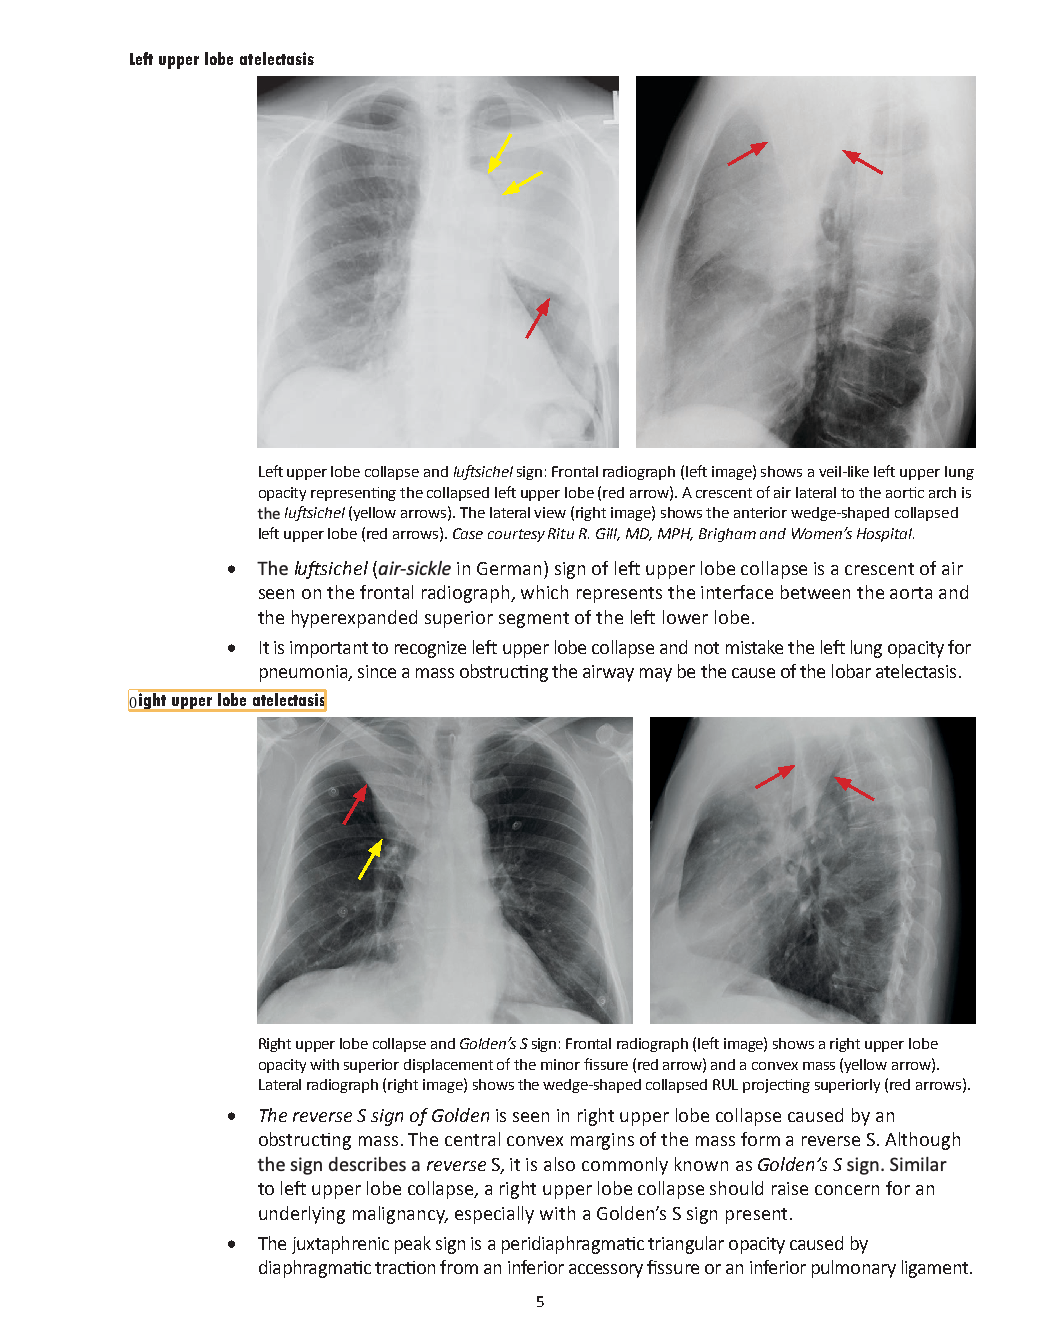

In [25]:
from layoutparser.elements import Layout, Interval
from pdfplumber.page import Page
from pdfplumber.display import PageImage

def get_labels(im, return_split_idx=False, pad=0.05) -> Layout:
    if type(im) is PageImage:
        im = im.annotated
    
    w,h = im.size
    
    layout = model.detect(im) # Detect the layout of the input image
    # print(layout)
    
    text_blocks: Layout = lp.Layout([b for b in layout if b.type in ('Text', 'Title')]) 
    nontext_blocks: Layout = lp.Layout([b for b in layout if b.type in ('Figure', 'Table')])
    
    # As there could be text region detected inside the figure region, we just drop them:
    text_blocks: Layout = lp.Layout([b for b in text_blocks if not any(b.is_in(b_fig, center=True) for b_fig in nontext_blocks)])

    # canvas_height=h, canvas_width=w
    left_interval: Interval = lp.Interval(0, w/2*(1.0+pad), axis='x').put_on_canvas(im)

    left_blocks = text_blocks.filter_by(left_interval, center=True)
    right_blocks = [b for b in text_blocks if b not in left_blocks]

    sort_key = lambda b: b.coordinates[1]
    left_blocks = sorted(left_blocks, key=sort_key)
    right_blocks = sorted(right_blocks, key=sort_key)
    text_blocks = [b.set(id=idx) for idx, b in enumerate(left_blocks + right_blocks)]
    
    for i, b in enumerate(text_blocks):
        for c in text_blocks[:i] + text_blocks[i+1:]:   # get all but b
            if b.is_in(c, center=True):
                b = b.set(parent=c.id)
                print(f"%%% Text block {b.id} is inside {b.parent} -- skipping")

    if return_split_idx:
        return text_blocks, len(left_blocks)
    else:
        return text_blocks


pg = pages[4]
im = pg.to_image(resolution=123).annotated
sorted_boxes = get_labels(im)

lp.draw_box(im, sorted_boxes, box_width=3, show_element_id=True)

# experimenting with image extractor

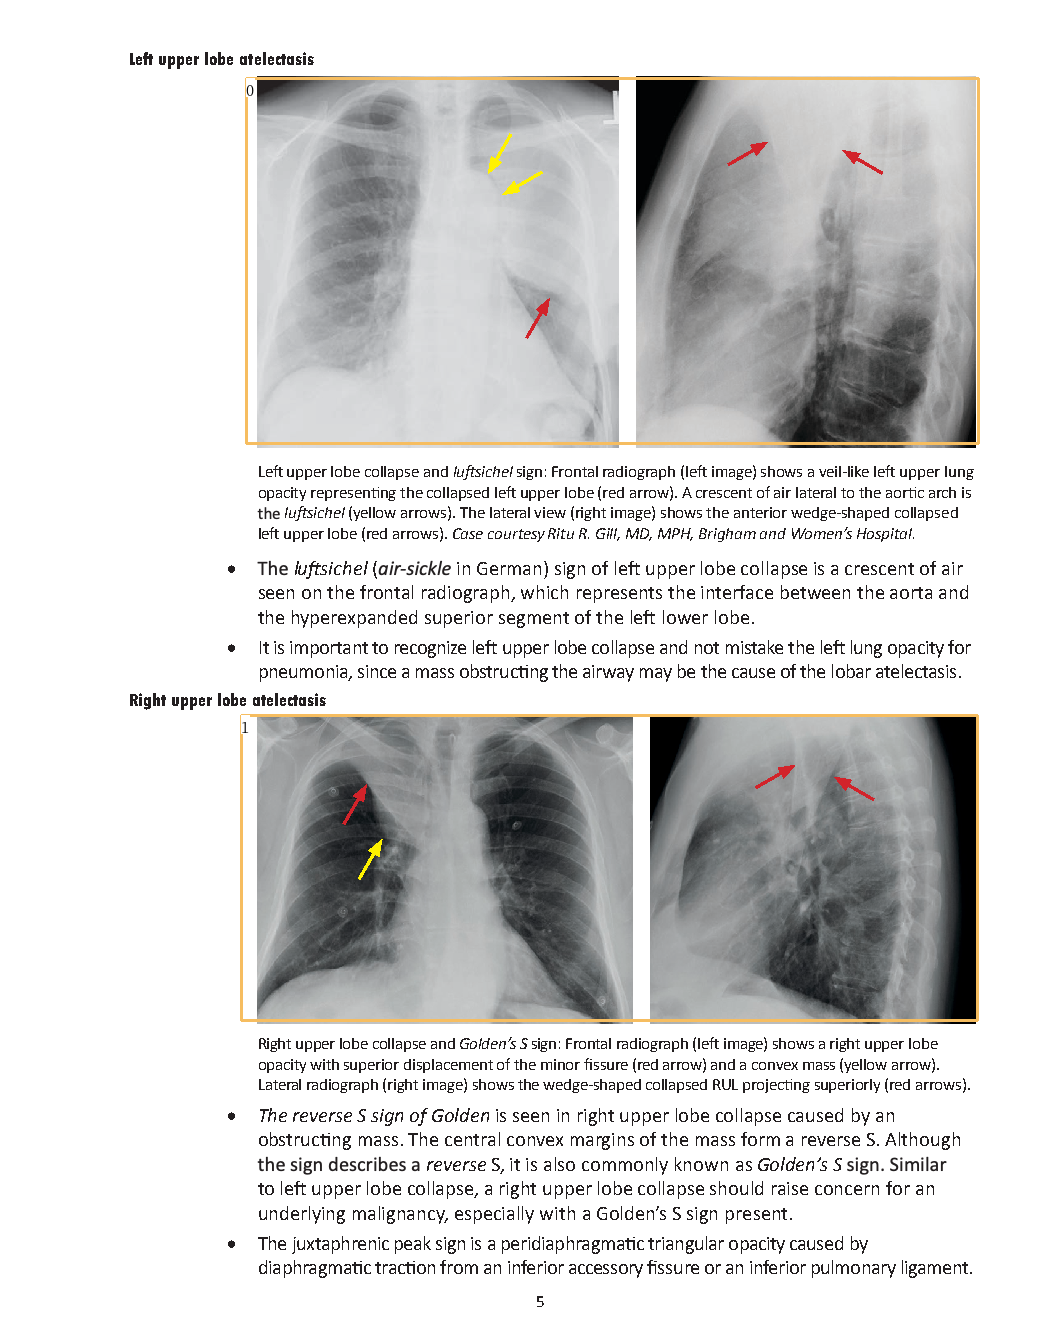

In [26]:
from layoutparser.elements import Layout, Interval
from pdfplumber.page import Page
from pdfplumber.display import PageImage

def get_images(im, return_split_idx=False, pad=0.05) -> Layout:
    if type(im) is PageImage:
        im = im.annotated
    
    w,h = im.size
    
    layout = model.detect(im) # Detect the layout of the input image
    # print(layout)
    
    nontext_blocks: Layout = lp.Layout([b for b in layout if b.type in ('Figure', 'Table')])
    
    for i, b in enumerate(nontext_blocks):
        for c in nontext_blocks[:i] + nontext_blocks[i+1:]:   # get all but b
            if b.is_in(c, center=True):
                b = b.set(parent=c.id)
                print(f"%%% Text block {b.id} is inside {b.parent} -- skipping")

    if return_split_idx:
        return nontext_blocks, len(left_blocks)
    else:
        return nontext_blocks


pg = pages[4]
im = pg.to_image(resolution=123).annotated
sorted_boxes = get_images(im)

lp.draw_box(im, sorted_boxes, box_width=3, show_element_id=True)

## tracker

In [28]:
from collections import defaultdict

class ChapterEntry(defaultdict):
    
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
    # body_font = set()
    # header_font = set()
    # label_end = label_start = -1
    # pg_end = pg_start = pg_curr = -1

TOK_LABEL_END = '[LABEL_END]'
TOK_STARTUP = '[STARTUP]'
TOK_FONTBREAK = '[FONTBREAK]'
TOK_NOFONT = ('[NOFONT]', -1)

In [29]:
# todo better way to manage these -- write to config file?
font_blacklist: Set[Tuple[str, float]] = set()
font_bodies: Set[Tuple[str, float]] = set()
font_headers: Set[Tuple[str, float]] = set()

In [61]:
class ChapterTracker:
    skip_interruping_header = True
    skip_font_label_mismatch = False    # issue: causes skip_interrupting_header to be ignored
    assert skip_interruping_header and skip_font_label_mismatch is False
    multifont_new_entry = False         # not implemented
    close_rstrip = True
    clean_merge = False  # ensure there is a single space between existing text and the new entry
    
    early_exit_txts = ('SUGGESTED READING')
    
    modes = {'startup', 'header', 'body'}
    types = {'Title', 'Text', 'Figure', 'Table'}
    
    def  __init__(self, mode='startup', entries=None) -> None:
        self.mode = mode
        assert self.mode in self.modes
        self.entries: List[ChapterEntry] = entries or []    # having the argument as a list mutates it; copies chapter-to-chapter entries.
        self.header = self.body = ''
        self.body_font = set()
        self.header_font = set()
        self.label_end = self.label_start = -1
        self.pg_end = self.pg_start = self.pg_curr = -1
        self.images = []
        
    # @property
    # def current_font(self):
    #     return self.header_font if self.mode == 'header' else self.body_font
        
    def close(self):
        if self.body == self.header == '':
            return
        if self.mode != 'body':
            print(f"### Closed while in {self.mode} -- we should only close when in `body` mode")
        if self.close_rstrip:
            self.header, self.body = self.header.rstrip(), self.body.rstrip()
        self.header_font, self.body_font = self.header_font or [TOK_NOFONT], self.body_font or [TOK_NOFONT]
        self.entries.append(dict(
                label_range=[self.label_start, self.label_end], pg_range=[self.pg_start, self.pg_end], 
                header_font=self.header_font, header=self.header, body_font=self.body_font, body=self.body,
                images = self.images)
            )
        self.__init__(entries=self.entries)
        
    def get_entries(self) -> List[ChapterEntry]:
        self.close()
        return self.entries
    
    def font_log(self, fonts: List[Tuple[str, float]], mode, k=4):
        inner_font = r'^([A-Z]+)\+(\w+?)-(\w+?)$'
        fonts = [((re.sub(inner_font, r'\2', font) if re.search(inner_font, font) else inner_font), round_to_nearest_k(size, k)) for font, size in fonts]
        
        if mode == 'header':
            font_headers.union(fonts)
        else:
            font_bodies.union(fonts)
    
    def font_category(self, fonts: List[Tuple[str, float]]) -> str:
        # TODO track avg font size for each
        cnt_header = sum([font in font_headers for font in fonts])
        cnt_body = sum([font in font_bodies for font in fonts])
        return 'body' if cnt_body > cnt_header else 'header'
        
    def font_parse(self, label_type, fonts: List[Tuple[str, float]], txt) -> bool:
        assert label_type in self.types
        label_mode = 'header' if label_type == 'Title' else 'body'
        
        if len(fonts)>1 and self.multifont_new_entry:   # and any([font in others for font in fonts])
            raise NotImplementedError
            return False
        if not (self.header_font if self.mode == 'header' else self.body_font):
        # if not self.current_font: # ! this line breaks 
            if label_mode=='header':
                self.header_font = set([max(fonts, key=lambda f: f[1])]) # largest font
            else:
                self.body_font = set([fonts[0]])   # most frequent font
            return True
        else:
            if self.font_category(fonts) != label_mode:
                if self.skip_font_label_mismatch:
                    self.close()
                    self.body_font = set(fonts)
                    self.header_font = set(fonts)
                    self.header = TOK_FONTBREAK
                    self.body = txt
                    self.mode = "body"
                return False
            if label_mode=='header':
                self.header_font.add(max(fonts, key=lambda f: f[1]))
            else:
                self.body_font.add(fonts[0])
        
        return True

    def add_img(self, img, label_type, ref):
        assert label_type in self.types
        if not img: return
        img.save(ref)
        print(f'saved at {ref}')
        self.images.append(ref)
    
    def add_txt(self, txt: str, label_type: str, fonts: List[Tuple[str, float]], pg_num: int, label_num: int):
        assert label_type in self.types
        if not txt: return
        txt = process_text(txt) # pg_num=pg_num
        if not txt: return
        
        if any([font in font_blacklist for font in fonts]):
            print(f'!!! blacklisted font, skipping `{txt}`')
            return
        

        log_font_mode: str = None
        # mode to which the font will be logged to
        # only set if confident the label correctly matches, i.e. we are extending the entry
        
        if txt in self.early_exit_txts:
            self.close()
            return
        
        if label_type == "Title":
            if self.mode == "header":
                if self.clean_merge:
                    self.header = self.header.rstrip() + " " + txt.lstrip()
                else:
                    self.header += txt
            else:
                if not ends_with(self.body) and self.skip_interruping_header and pg_num == self.pg_curr:
                    print(f'>>> interrupting header, skipping `{txt}`')
                    return
                self.close()
                self.header = txt
                self.mode = "header"
            log_font_mode = "header"

        elif label_type == "Text":
            if txt.endswith(TOK_SENTENCE_TERMS):
                # txt += (f"\n {TOK_LABEL_END} \n" if TOK_LABEL_END else '\n')
                txt += '\n'
            if self.mode == 'header':
                self.body = txt
                log_font_mode = "body"
            else:
                if self.mode == "body":
                    self.log_font_mode = "body"
                if self.mode == "startup" and self.header == '':
                    self.header = TOK_STARTUP
                if not re.search(r"\s+$", self.body) and not re.search(r"^\s+", txt):
                    txt = " " + txt # insert space if existing body doesn't end with whitespace
                if self.clean_merge:
                    self.body = self.body.rstrip() + " " + txt.lstrip()
                else:
                    self.body += txt
            self.mode = "body"
        
        if self.pg_curr < pg_num:
            self.pg_curr = pg_num
            
        if self.pg_start < 0:
            self.pg_start = pg_num
        if self.label_start < 0:
            self.label_start = label_num
        
        self.pg_end, self.label_end = pg_num, label_num
        
        if not self.font_parse(label_type, fonts, txt):
            # this works now, but should be placed above
            # to raise an error when the current font isn't in [body/header]_font 
            return
        if log_font_mode:
            self.font_log(fonts, log_font_mode)

## Main

In [62]:
from layoutparser.elements import TextBlock
from tqdm.notebook import tqdm
import json

def process_file_tracker(
    fname: Path,
    # pad=0.010,
    pad=0.0075,
    # pad=0.005,
    resolution=123,
    laparams=dict(detect_vertical=False)
    # laparams=dict(detect_vertical=False, word_margin=0.08)    # this doesn't cause any difference?
):
    assert 0<=pad<1
    
    pdf = pdfplumber.open(fname, laparams=laparams).pages
    
    outdir = Path("scrape_out")
    outdir /= fname.stem
    outdir.mkdir(parents=True, exist_ok=True)

    imgdir = Path(f"scrape_out/{fname.stem}/images")
    imgdir.mkdir(parents=True, exist_ok=True)
    image_count = 0

    config = Config(fname)
    # chapters = [config.chapter_range()[0]]
    chapters = config.chapter_range()
    for i, ch in enumerate(chapters,1):
        print(f"Processing ch{i}")
        start, end = ch
        pages = pdf[start:end]
        tracker = ChapterTracker()
        
        progress = tqdm(pages)
        for pg in progress:
            pg_num = pg.page_number
            im = pg.to_image(resolution=resolution).annotated
            w_im,h_im = im.size
            w_pg,h_pg = pg.width,pg.height
            w_ratio,h_ratio = w_pg/w_im,h_pg/h_im

            # Text extractor
            # TODO: pass coordinates as well ?
            labels = get_labels(im)
            for label_num, label in enumerate(labels):
                # print(label)
                label: TextBlock
                if label.parent is not None: 
                    print(f"%%% Text block {label.id} is inside {label.parent} -- skipping")
                    continue
                pad_x, pad_y = pad*w_im, pad*h_im
                label = label.pad(left=pad_x, right=pad_x, top=pad_y, bottom=pad_y)
                x0,y0,x1,y1 = label.coordinates
                x0,x1 = x0*w_ratio, x1*w_ratio
                y0,y1 = y0*h_ratio, y1*h_ratio
                
                kind = label.type
                assert kind in ("Text", "Title")
                
                area = pg.within_bbox((x0,y0,x1,y1))
                fonts = extract_fonts(area)
                txt = area.extract_text()
                tracker.add_txt(txt, kind, fonts, pg_num, label_num)

            # Image extractor
            # TODO: pass coordinates as well ?
            images = get_images(im)
            for image_num, image in enumerate(images):
                image: TextBlock
                if image.parent is not None: 
                    print(f"%%% Image block {image.id} is inside {image.parent} -- skipping")
                    continue
                x0,y0,x1,y1 = image.coordinates
                x0,x1 = x0*w_ratio, x1*w_ratio
                y0,y1 = y0*h_ratio, y1*h_ratio
                
                kind = image.type
                assert kind in ('Figure', 'Table')

                area = pg.within_bbox((x0,y0,x1,y1))
                img = area.crop((x0,y0,x1,y1)).to_image()
                tracker.add_img(img, kind, f"{outdir}/images/{image_count}.png")
                image_count += 1
                
                
        tracker.close()
        
        with open(outdir / f"ch{i}_tracker.json", "w", encoding="utf8") as f:
            print(f"*** saving to {f.name}")
            data = tracker.get_entries()
            data = [{k: (list(v) if type(v) is set else v) for k,v in entry.items()} for entry in data] # json-ify: tuples -> lists
            
            # json.dump(data, f, indent=2, ensure_ascii=False)
            s = json.dumps(data, indent=2, ensure_ascii=False)
            s = compact_json(s)
            f.write(s)

In [63]:
process_file_tracker(fname)

Processing ch1


  0%|          | 0/86 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/0.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/1.png
>>> interrupting header, skipping `Lobar atelectasis`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/2.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/3.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/4.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/5.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/6.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/7.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/8.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/9.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/10.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/11.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/1

  0%|          | 0/70 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/124.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/125.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/126.png
### Failed to dehyphenate word: in-(left 
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/127.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/128.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/129.png
>>> interrupting header, skipping `Malignant hepatic masses`
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/130.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/131.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/132.png
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
%%% Text block None is inside None

  0%|          | 0/44 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/191.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/192.png
### Failed to dehyphenate word: HII‘_-_.|__H 
### Failed to dehyphenate word: __I|_I“_|_1l|__r___I_II-_r-‘__I|_mFJIIIIIWIHII‘
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/193.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/194.png
>>> interrupting header, skipping `biochemical approach to adrenal lesions`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/195.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/196.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/197.png
>>> interrupting header, skipping `Adrenal calcification`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/198.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/199.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/image

  0%|          | 0/145 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/250.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/251.png
>>> interrupting header, skipping `cerebral edema`
>>> interrupting header, skipping `Vasogenic edema`
>>> interrupting header, skipping `Interstitial edema`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/252.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/253.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/254.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/255.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/256.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/257.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/258.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/259.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/260.png
saved at scrape_o

  0%|          | 0/118 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/416.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/417.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/418.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/419.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/420.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/421.png
>>> interrupting header, skipping `Erosive osteoarthritis of the hands`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/422.png
%%% Text block None is inside None -- skipping
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/423.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/424.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/425.png
>>> interrupting header, skipping `Rheumatoid arthritis in the elbow`
>>> interrupting header, skipping `Inflammatory bowel disease

  0%|          | 0/89 [00:00<?, ?it/s]

%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/562.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/563.png
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/564.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/565.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/566.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/567.png
>>> interrupting header, skipping `Adenomyomatosis`
>>> interrupting header, skipping `Strawberry gallbladder (cholesterolosis of the gallbladder)`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/568.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/569.png
saved at scrape_o

  0%|          | 0/39 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/652.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/653.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/654.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/655.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/656.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/657.png
>>> interrupting header, skipping `Image interpretation`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/658.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/659.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/660.png
>>> interrupting header, skipping `Diagnostic Indications (I123 or tc99m pertechnetate)`
>>> interrupting header, skipping `Ectopic thyroid`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/661.png
saved at scrape_out/General - Mandell - Core Radiolo

  0%|          | 0/66 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/684.png
>>> interrupting header, skipping `mediallateral-oblique (MLO)`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/685.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/686.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/687.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/688.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/689.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/690.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/691.png
>>> interrupting header, skipping `benign calcifications (b Ir ADs 2)`
>>> interrupting header, skipping `Skin calcifications`
>>> interrupting header, skipping `Vascular calcifications`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/692.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/693.png

  0%|          | 0/36 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/761.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/762.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/763.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/764.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/765.png
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/766.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/767.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/768.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/769.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/770.png
%%% Text block None is inside None -- skipping
%%% Text block 

  0%|          | 0/47 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/810.png
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/811.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/812.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/813.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/814.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/815.png
>>> interrupting header, skipping `Hematoma`
>>> interrupting header, skipping `Pseudoaneurysm`
>>> interrupting header, skipping `Arteriovenous fi stula (AVF)`
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/816.png
>>> interrupting header, skipping `Stents`
>>> interrupting header, skipping `catheters`
>>> interrupting header, skipping `th

  0%|          | 0/97 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/877.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/878.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/879.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/880.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/881.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/882.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/883.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/884.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/885.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/886.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/887.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/888.png
>>> interrupting header, skipping `Innominate artery syndrome`
saved at scrape_out/General - Mandell

  0%|          | 0/25 [00:00<?, ?it/s]

saved at scrape_out/General - Mandell - Core Radiology (1e)/images/1005.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/1006.png
>>> interrupting header, skipping `Mild contrast reactions`
>>> interrupting header, skipping `Moderate contrast reactions`
>>> interrupting header, skipping `Severe contrast reactions`
>>> interrupting header, skipping `Premedication to prevent contrast reaction`
>>> interrupting header, skipping `Iodinated contrast and thyroid uptake`
>>> interrupting header, skipping `Metformin and intravenous contrast`
### Failed to dehyphenate word: org/Quality-Safety/Resources/Contrast-manual, 
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/1007.png
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
%%% Text block None is inside None -- skipping
saved at scrape_out/General - Mandell - Core Radiology (1e)/images/1008.png
saved at scrape_out/General - Mandell - Core Radiology (1e)/images

# post processing

- everything we can't greedily use regex for
- detect..
    - conjugated words
    - figures
    - skipped/missing text
    - out of order sentences
    - duplicated sentences
- for these capabilities, will need to log font size+family+relative position of each textbox
- should also have some method to catch skipped boxes (i.e. those not recognized by layout parser OCR -- notably lists are buggy)

In [ ]:
# TODO

# appendix

## example snippets

### extract fonts

TextBlock(block=Rectangle(x_1=107.79412078857422, y_1=990.101806640625, x_2=240.0605926513672, y_2=1010.4228515625), text=None, id=1, type=Text, parent=None, next=None, score=0.7693758606910706)


[('TwCenMT', 11.0)]

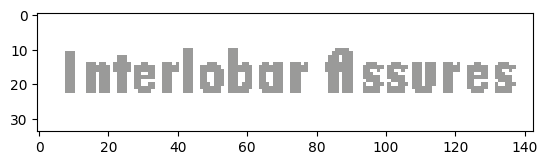

In [65]:
box = sorted_boxes[1]
print(box)
x0,y0,x1,y1 = box.coordinates

w_im,h_im = im.size
w_pg,h_pg = pg.width,pg.height
w_ratio,h_ratio = w_pg/w_im,h_pg/h_im
pad=0.005
x0,x1 = (x0-pad*w_im)*w_ratio, (x1+pad*w_im)*w_ratio
y0,y1 = (y0-pad*h_im)*h_ratio, (y1+pad*h_im)*h_ratio

y1 *= 1

area = pg.within_bbox((x0,y0,x1,y1))
area_im = area.to_image(resolution=123).annotated
plt.imshow(area_im)
extract_fonts(area)

### layout parser 

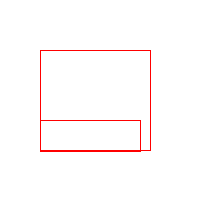

In [58]:
import layoutparser as lp
import numpy as np

# block_A = lp.Rectangle(50, 50, 150, 150)
# block_B = lp.Rectangle(40, 60, 160, 30)
block_A = lp.Rectangle(40, 50, 150, 150) 
block_B = lp.Rectangle(40, 120, 140, 151)

lp.draw_box(np.ones((200,200,3), dtype='uint8')*255, [block_A, block_B])

In [59]:
print(block_A.is_in(block_B))
print(block_B.is_in(block_A))
print(block_A.is_in(block_B, center=True))
print(block_B.is_in(block_A, center=True))

False
False
False
True


## unfinished/broken/abandoned code

### overlap detection 

- current approach with layoutparser seems good enough
- this 'manual' approach is  not done

** ignoring overlap case (contained)
1 1 8 12
6 2 11 10


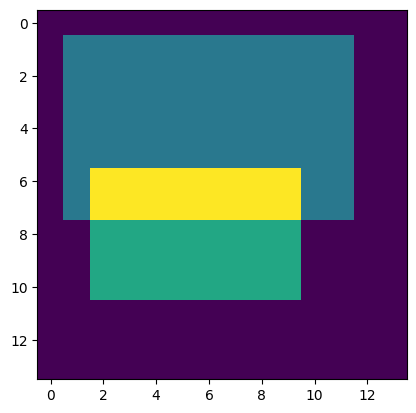

In [ ]:
# TODO finish this
import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor

def place(i,j,data,itm,center=False):
    h,w=itm.shape
    
    if center: 
        i-=h//2
        j-=w//2
    
    data[i:i+h,j:j+w]+=itm
    return data

def rm_overlap(rect0: List[int],rect1: List[int], favor=0, interp=0.66) -> Tuple[List[int], List[int]]:
    assert 0<=interp<=1
    
    x0,y0,x1,y1=rect0
    a0,b0,a1,b1=rect1
    
    # no overlap
    if x1<a0 or a1<x0 or y1<b0 or b1<y0:
        return rect0, rect1
    
    # boxes overlap in x, and y
    if not (x1<a0 or a1<x0) and not (y1<b0 or b1<y0):
        p,q=interp,1-interp
        
        if y0<b0<y1<b1:     # rect0 above rect1
            margin = y1-b0
            y1-=margin*(q if favor else p)
            b0+=margin*(p if favor else q)
            y1,b0=floor(y1),ceil(b0)            
        elif b0<y0<b1<y1:   # rect0 below rect1
            margin = b1-y0
            y0+=margin*(q if favor else p)
            b1-=margin*(p if favor else q)
            y0,b1=ceil(y0),floor(b1)
        else:
            print('** ignoring overlap case (contained)')
    
    # y0,b0=max(y0,0),max(b0,0)
    return [x0,y0,x1,y1], [a0,b0,a1,b1]
    

n = 14
data = np.zeros((n,n))

a_dim = (7,11)
a_off = (1,1)
a = np.ones(a_dim)/3.0
ax0,ay0 = a_off
ax1,ay1 = [a+i for a,i in zip(a_off,a.shape)]


b_dim = (5,8)
b_off = (6,2)
b = np.ones(b_dim)/2.0
bx0,by0 = b_off
bx1,by1 = [b+i for b,i in zip(b_off,b.shape)]

(ax0,ay0,ax1,ay1), (bx0,by0,bx1,by1) = rm_overlap((ax0,ay0,ax1,ay1), (bx0,by0,bx1,by1))
place(*a_off,data,a)
print(ax0,ay0,ax1,ay1)
place(*b_off,data,b)
print(bx0,by0,bx1,by1)

plt.imshow(data, interpolation='nearest');

### typing entry

In [ ]:
from collections import defaultdict
from typing import TypedDict

class ChapterEntry(defaultdict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    header_font: List[Tuple[str, float]]
    header: str
    body_font: List[Tuple[str, float]]
    body: str
    label_start: int
    label_end: int
    pg_start: int
    pg_end: int
# type FontPair = Tuple[str, float]     # need python 3.12

## old code

### `pdfplumber`

In [75]:
import pdfplumber

pdf = pdfplumber.open(fname, laparams={"detect_vertical": False}).pages

In [76]:
start, end = config.chapter_range()[0]
pages = pdf[start:end]
pg = pages[3]
pg.to_image(resolution=123).draw_rects(pg.textboxhorizontals).show()

In [77]:
# text = pg.extract_text()
# print(text)

words = pg.extract_words()
words = pg.extract_words(use_text_flow=True, x_tolerance=7, keep_blank_chars=True)
print(" ".join([w['text'] for w in words]))

Patterns of lobar atelectasis frontal schematic LUL RUL ~~ __ \‘ _ _& ~ ~~~‘I’ II _ % ~ %_ “ %_ \ \\\ lll\ " _ _ . _ \\ ’I ‘ \\ "\\\ II \\ Ik I I I I II \\“ ‘ § M §§ R,‘% \Q RML Q n Q u _ u*"“ u I O - _ II II I II I I I \\\ \\\ \\\ \\\\ In \‘ I \\\ I’ \’\\ ’ \\I’ \ I \\ \\\ \\ \“ LLL RLL right lung left lung RUL “‘I'll \“I,’ \‘ I _ “_ ‘ ‘ . \‘ ‘\ ‘\‘ _ \__W Iv \ \ \I II \‘ Flll " RML 4lll. lateral schematic LUL ‘\\ \:‘ ‘\' “ \\\‘ \\III‘ ‘ ‘‘\ ‘‘ ‘\‘ l|llll"| \\ K‘ \II \III \\\ ‘--|-"-"- \I ‘\lIll||lI \III II I I III II II IIIII IIII III III U I I ‘-I- I III Ill I I I It \ \\\,III \ ll II I I II RLL LLL right lung left lung •	 Each of the five lobes tends to collapse in a predictable direction, as shown above. 4


In [131]:
from layoutparser.elements import TextBlock

def process_page_DNN(pg: Page, pad=0.005, resolution=123):
    assert 0<=pad<1
    continuation = ""   # base text continuing from previous page's last entry
    mode = "startup"    # startup, header, body
    entries = []        # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False        # whether we've reached the end of the chapter (e.x. sugguested readings section)
    
    SKIP_BADPUNC = True
    
    pg_num = pg.page_number
    im = pg.to_image(resolution=resolution).annotated
    labels = get_labels(im)
    
    w_im,h_im = im.size
    w_pg,h_pg = pg.width,pg.height
    w_ratio,h_ratio = w_pg/w_im,h_pg/h_im
    
    for j,label in enumerate(labels):
        label: TextBlock
        pad_x, pad_y = pad*w_im, pad*h_im
        label = label.pad(left=pad_x, right=pad_x, top=pad_y, bottom=pad_y)
        # print(label)
        
        kind = label.type
        # assert kind in ("Text", "Title")
                
        x0,y0,x1,y1 = label.coordinates
        x0,x1 = x0*w_ratio, x1*w_ratio
        y0,y1 = y0*h_ratio, y1*h_ratio

        area = pg.within_bbox((x0,y0,x1,y1))

        if kind in ("Text", "Title"):
            fonts = extract_fonts(pg)   # TODO continue iff font matches previous
            txt = area.crop()
            # print(txt)
            txt = process_text(txt, pg_num=pg_num)
            # print(txt)
            
            if txt == 'SUGGESTED READING':
                print(f'### PG {pg_num} :: Found end of chapter, stopping early ###')
                done = True
                if mode == "body":
                    entries.append(current_entry)
                    # entries.append([ent.rstrip() for ent in current_entry])
                return entries, continuation.rstrip(), done

            if kind == "Title":
                match mode:
                    case "header":
                        current_entry[0] += txt
                    case "startup":
                        if continuation!="" and not continuation.rstrip().endswith(TOK_SENTENCE_TERMS):
                            print(f'### PG {pg_num}, Box {j} :: Continuation does not end with punctuation: {continuation.rstrip()[-1]}')
                            if SKIP_BADPUNC: 
                                print(f'### > skipping `{txt}`')
                                continue
                        mode = "header"
                        current_entry = [txt, ""]
                    case "body":
                        if current_entry[1]!="" and not current_entry[1].rstrip().endswith(TOK_SENTENCE_TERMS):
                            print(f'### PG {pg_num}, Box {j} :: Body does not end with punctuation: {current_entry[1].rstrip()[-1]}')
                            if SKIP_BADPUNC: 
                                print(f'### > skipping `{txt}`')
                                continue
                        mode = "header"
                        entries.append(current_entry)
                        # entries.append([ent.rstrip() for ent in current_entry])
                        current_entry = [txt, ""]
            elif kind == "Text":
                match mode:
                    case "header":
                        mode = "body"
                        current_entry[1] += txt
                    case "startup":
                        if txt.endswith(TOK_SENTENCE_TERMS):
                            txt += "\n"
                        continuation += txt
                    case "body":
                        # if re.match(r'[.?!]', txt[-1]):
                        if txt.endswith(TOK_SENTENCE_TERMS):
                            txt += "\n"
                        current_entry[1] += txt

    match mode:
        case "body":
            # entries.append([ent.rstrip() for ent in current_entry])
            entries.append(current_entry)
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")
    
            
    continuation = process_text(continuation)
    for i, (_h, b) in enumerate(entries):
        entries[i][1] = process_text(b)

    return entries, continuation, done

In [124]:
ent, cont, done = process_page_DNN(pg)

print('\n' + '='*60)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

Layout(_blocks=[TextBlock(block=Rectangle(x_1=246.48963928222656, y_1=78.03372192382812, x_2=978.2208862304688, y_2=443.8672180175781), text=None, id=None, type=Figure, parent=None, next=None, score=0.9958802461624146), TextBlock(block=Rectangle(x_1=241.49267578125, y_1=715.4127807617188, x_2=977.7689819335938, y_2=1020.5606079101562), text=None, id=None, type=Figure, parent=None, next=None, score=0.9919597506523132), TextBlock(block=Rectangle(x_1=229.37704467773438, y_1=1041.241943359375, x_2=967.0467529296875, y_2=1274.6651611328125), text=None, id=None, type=List, parent=None, next=None, score=0.9890110492706299), TextBlock(block=Rectangle(x_1=129.15890502929688, y_1=690.24072265625, x_2=325.67657470703125, y_2=710.0797119140625), text=None, id=None, type=Title, parent=None, next=None, score=0.9823071956634521), TextBlock(block=Rectangle(x_1=228.14312744140625, y_1=463.4031677246094, x_2=982.053955078125, y_2=681.5524291992188), text=None, id=None, type=List, parent=None, next=None,

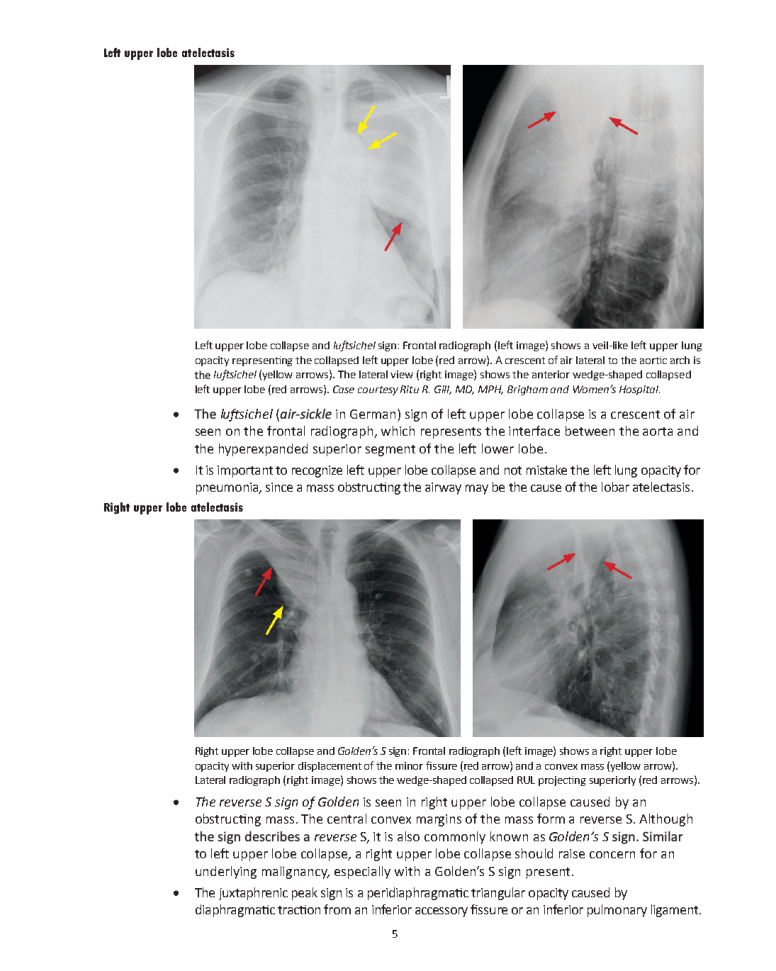

In [125]:
im = pg.to_image(resolution=123).annotated
plt.figure(figsize=(10,10), dpi=123)
plt.axis("off")
plt.imshow(im);

In [82]:
from tqdm.notebook import tqdm
import json

def process_file(fname: Path):
    config = Config(fname)
    chapters = config.chapter_range()
    # chapters = [config.chapter_range()[0]]
    pdf = pdfplumber.open(fname, laparams=dict(detect_vertical=False)).pages
    # word_margin=0.08  -- this doesn't cause any difference?
    
    for i, ch in enumerate(chapters,1):
        # pdf: fitz.Document = fitz.open(fname)
        # pdf.select(range(*ch))
        
        start, end = ch
        pages = pdf[start:end]
        
        print(f"Processing ch{i}")

        ch_entries = []
        
        progress = tqdm(pages)
        for pg in progress:
        # for pg in pdf:
            entries, cont, done = process_page_DNN(pg)
            # entries, cont, done = process_page(pg)

            if cont:
                if len(ch_entries):
                    ch_entries[-1][1] = ch_entries[-1][1] + cont
                else:
                    ch_entries.append(["[Chapter Introduction]", cont])

            ch_entries += entries

            if done:
                progress.close()
                break

        outdir = Path("scrape_out_old")
        outdir /= fname.stem
        outdir.mkdir(parents=True, exist_ok=True)
        with open(outdir / f"ch{i}.json", "w", encoding="utf8") as f:
            json.dump(ch_entries, f, indent=False, ensure_ascii=False)
            print(f"Saved to {f.name}")
            
process_file(fname)

Processing ch1


  0%|          | 0/86 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=104.80734252929688, y_1=193.57278442382812, x_2=973.8204956054688, y_2=1330.8260498046875), text=None, id=None, type=Figure, parent=None, next=None, score=0.9799686670303345)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=202.29281616210938, y_1=1014.3544311523438, x_2=939.4034423828125, y_2=1252.98583984375), text=None, id=None, type=List, parent=None, next=None, score=0.9926942586898804), TextBlock(block=Rectangle(x_1=199.04989624023438, y_1=175.96133422851562, x_2=951.5613403320312, y_2=973.5158081054688), text=None, id=None, type=Figure, parent=None, next=None, score=0.9745982885360718), TextBlock(block=Rectangle(x_1=85.97779846191406, y_1=127.90338134765625, x_2=177.96737670898438, y_2=157.1876983642578), text=None, id=None, type=Title, parent=None, next=None, score=0.793149471282959), TextBlock(block=Rectangle(x_1=107.79412078857422, y_1=990.101806640625, x_2=240.0605926513672, y_2=1010.4228515625), text=None, id=None, 

  0%|          | 0/70 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=105.42760467529297, y_1=161.02857971191406, x_2=979.71826171875, y_2=1337.0), text=None, id=None, type=Figure, parent=None, next=None, score=0.9633692502975464), TextBlock(block=Rectangle(x_1=244.32260131835938, y_1=162.75225830078125, x_2=836.59326171875, y_2=219.9320068359375), text=None, id=None, type=Title, parent=None, next=None, score=0.7219241261482239)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=294.7850341796875, y_1=671.0233154296875, x_2=924.5550537109375, y_2=1224.9267578125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9873097538948059), TextBlock(block=Rectangle(x_1=427.5943603515625, y_1=274.5462646484375, x_2=901.692138671875, y_2=602.1845092773438), text=None, id=None, type=Figure, parent=None, next=None, score=0.9395710825920105), TextBlock(block=Rectangle(x_1=85.07550811767578, y_1=130.43150329589844, x_2=233.45065307617188, y_2=155.5784912109375), text=None, id=None, type=Title, par

  0%|          | 0/44 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=106.14791870117188, y_1=208.10821533203125, x_2=973.0776977539062, y_2=1335.02685546875), text=None, id=None, type=Figure, parent=None, next=None, score=0.9810090065002441)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=206.2955322265625, y_1=1009.4426879882812, x_2=954.6600341796875, y_2=1239.8984375), text=None, id=None, type=List, parent=None, next=None, score=0.9922230839729309), TextBlock(block=Rectangle(x_1=381.279541015625, y_1=169.08486938476562, x_2=778.5956420898438, y_2=197.6214141845703), text=None, id=None, type=Title, parent=None, next=None, score=0.9818776845932007), TextBlock(block=Rectangle(x_1=107.31983947753906, y_1=192.16989135742188, x_2=942.5052490234375, y_2=1031.393310546875), text=None, id=None, type=Figure, parent=None, next=None, score=0.9450250864028931)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=128.71730041503906, y_1=778.0985107421875, x_2=297.6308898925781, y_2=798.7828369140

  0%|          | 0/145 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=87.1907730102539, y_1=247.733642578125, x_2=992.4927978515625, y_2=1290.452392578125), text=None, id=None, type=Figure, parent=None, next=None, score=0.932100772857666)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=196.03858947753906, y_1=1060.730712890625, x_2=824.3668212890625, y_2=1100.0211181640625), text=None, id=None, type=Text, parent=None, next=None, score=0.9906807541847229), TextBlock(block=Rectangle(x_1=106.28180694580078, y_1=146.8648223876953, x_2=909.38232421875, y_2=1045.7840576171875), text=None, id=None, type=Figure, parent=None, next=None, score=0.9623720049858093)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=152.5598602294922, y_1=851.71630859375, x_2=976.6593017578125, y_2=1288.0728759765625), text=None, id=None, type=List, parent=None, next=None, score=0.9694070816040039), TextBlock(block=Rectangle(x_1=189.7108154296875, y_1=128.70835876464844, x_2=979.8247680664062, y_2=359.146331787109

  0%|          | 0/118 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=66.60338592529297, y_1=185.09454345703125, x_2=914.519775390625, y_2=1337.0), text=None, id=None, type=Figure, parent=None, next=None, score=0.9622094035148621), TextBlock(block=Rectangle(x_1=221.7079620361328, y_1=163.60511779785156, x_2=824.0043334960938, y_2=241.99761962890625), text=None, id=None, type=Title, parent=None, next=None, score=0.8216946721076965)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=226.112548828125, y_1=732.5225219726562, x_2=956.3035888671875, y_2=1230.1328125), text=None, id=None, type=List, parent=None, next=None, score=0.9958721995353699), TextBlock(block=Rectangle(x_1=136.0062255859375, y_1=125.58541107177734, x_2=975.0608520507812, y_2=457.58184814453125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9585815072059631), TextBlock(block=Rectangle(x_1=203.06968688964844, y_1=499.38385009765625, x_2=965.7158813476562, y_2=650.2609252929688), text=None, id=None, type=List, paren

  0%|          | 0/89 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=78.88018035888672, y_1=184.57015991210938, x_2=932.5640258789062, y_2=1329.0772705078125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9364331960678101), TextBlock(block=Rectangle(x_1=84.40110778808594, y_1=750.1234130859375, x_2=961.8705444335938, y_2=1278.01318359375), text=None, id=None, type=Figure, parent=None, next=None, score=0.9181765913963318)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=229.2350616455078, y_1=677.4273681640625, x_2=954.8649291992188, y_2=1259.8782958984375), text=None, id=None, type=List, parent=None, next=None, score=0.9948397278785706), TextBlock(block=Rectangle(x_1=256.7022705078125, y_1=571.1875610351562, x_2=674.208251953125, y_2=631.504638671875), text=None, id=None, type=Text, parent=None, next=None, score=0.9921191930770874), TextBlock(block=Rectangle(x_1=257.57330322265625, y_1=187.42713928222656, x_2=687.5821533203125, y_2=554.6646728515625), text=None, id=None, type

  0%|          | 0/39 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=91.18701171875, y_1=154.4936981201172, x_2=974.0073852539062, y_2=1309.675048828125), text=None, id=None, type=Figure, parent=None, next=None, score=0.938994288444519)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=198.64170837402344, y_1=195.61041259765625, x_2=946.484619140625, y_2=370.7668762207031), text=None, id=None, type=List, parent=None, next=None, score=0.9944936037063599), TextBlock(block=Rectangle(x_1=109.45026397705078, y_1=377.2898254394531, x_2=314.92010498046875, y_2=398.2622985839844), text=None, id=None, type=Text, parent=None, next=None, score=0.9913622736930847), TextBlock(block=Rectangle(x_1=197.870361328125, y_1=960.1803588867188, x_2=942.1956176757812, y_2=1228.95166015625), text=None, id=None, type=List, parent=None, next=None, score=0.9912005066871643), TextBlock(block=Rectangle(x_1=230.45823669433594, y_1=419.8543701171875, x_2=962.241943359375, y_2=803.1408081054688), text=None, id=None, type=Figure

  0%|          | 0/66 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=72.98762512207031, y_1=200.88973999023438, x_2=969.8912963867188, y_2=1260.3048095703125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9253401160240173)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=211.78269958496094, y_1=139.5157470703125, x_2=975.1638793945312, y_2=616.4886474609375), text=None, id=None, type=List, parent=None, next=None, score=0.9972242116928101), TextBlock(block=Rectangle(x_1=218.94549560546875, y_1=707.3632202148438, x_2=977.61376953125, y_2=1282.503173828125), text=None, id=None, type=List, parent=None, next=None, score=0.9855332970619202), TextBlock(block=Rectangle(x_1=127.6714096069336, y_1=606.1873168945312, x_2=541.2723388671875, y_2=626.0562744140625), text=None, id=None, type=Text, parent=None, next=None, score=0.971478283405304), TextBlock(block=Rectangle(x_1=129.44140625, y_1=117.62142944335938, x_2=360.82672119140625, y_2=138.99795532226562), text=None, id=None, type=Text

  0%|          | 0/36 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=77.7734603881836, y_1=231.3820343017578, x_2=955.0675048828125, y_2=1304.9415283203125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9802603125572205), TextBlock(block=Rectangle(x_1=209.10183715820312, y_1=163.56163024902344, x_2=791.739501953125, y_2=221.3554229736328), text=None, id=None, type=Title, parent=None, next=None, score=0.7040799260139465)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=232.9757843017578, y_1=1138.167236328125, x_2=962.4332885742188, y_2=1263.4791259765625), text=None, id=None, type=List, parent=None, next=None, score=0.9592750668525696), TextBlock(block=Rectangle(x_1=224.5087890625, y_1=702.2798461914062, x_2=732.3656005859375, y_2=1123.7139892578125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9471904039382935), TextBlock(block=Rectangle(x_1=195.93934631347656, y_1=157.15513610839844, x_2=797.8673095703125, y_2=613.3855590820312), text=None, id=None, typ

  0%|          | 0/47 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=79.51671600341797, y_1=194.83480834960938, x_2=952.6499633789062, y_2=1337.0), text=None, id=None, type=Figure, parent=None, next=None, score=0.9633488655090332), TextBlock(block=Rectangle(x_1=226.50978088378906, y_1=161.105712890625, x_2=805.9183349609375, y_2=233.73902893066406), text=None, id=None, type=Title, parent=None, next=None, score=0.8054892420768738)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=98.86924743652344, y_1=717.52880859375, x_2=952.4534301757812, y_2=738.441650390625), text=None, id=None, type=Text, parent=None, next=None, score=0.9726689457893372), TextBlock(block=Rectangle(x_1=170.34730529785156, y_1=749.138671875, x_2=960.24560546875, y_2=1176.616943359375), text=None, id=None, type=List, parent=None, next=None, score=0.9523908495903015), TextBlock(block=Rectangle(x_1=103.60052490234375, y_1=400.79022216796875, x_2=237.63465881347656, y_2=419.2189636230469), text=None, id=None, type=Text, parent=Non

  0%|          | 0/97 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=94.69662475585938, y_1=267.6920471191406, x_2=975.892822265625, y_2=1291.5860595703125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9811697602272034)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=79.98451232910156, y_1=195.1062469482422, x_2=958.9356079101562, y_2=607.5773315429688), text=None, id=None, type=Figure, parent=None, next=None, score=0.9888783097267151), TextBlock(block=Rectangle(x_1=310.6902770996094, y_1=698.529541015625, x_2=750.1107788085938, y_2=1110.9375), text=None, id=None, type=Figure, parent=None, next=None, score=0.9869763255119324), TextBlock(block=Rectangle(x_1=313.14794921875, y_1=660.7833862304688, x_2=787.423583984375, y_2=680.2381591796875), text=None, id=None, type=Text, parent=None, next=None, score=0.9810529351234436), TextBlock(block=Rectangle(x_1=86.00389862060547, y_1=131.54148864746094, x_2=179.1752166748047, y_2=156.454345703125), text=None, id=None, type=Title, pare

  0%|          | 0/25 [00:00<?, ?it/s]

Layout(_blocks=[TextBlock(block=Rectangle(x_1=71.76178741455078, y_1=391.2483825683594, x_2=952.3604736328125, y_2=1255.676513671875), text=None, id=None, type=Figure, parent=None, next=None, score=0.8651286363601685)], page_data={})
Layout(_blocks=[TextBlock(block=Rectangle(x_1=88.96742248535156, y_1=151.191162109375, x_2=871.2183227539062, y_2=1231.6793212890625), text=None, id=None, type=Figure, parent=None, next=None, score=0.8854154348373413), TextBlock(block=Rectangle(x_1=625.7418212890625, y_1=119.71422576904297, x_2=916.413330078125, y_2=142.1422882080078), text=None, id=None, type=Text, parent=None, next=None, score=0.8448160886764526), TextBlock(block=Rectangle(x_1=173.86184692382812, y_1=120.3780746459961, x_2=501.30621337890625, y_2=142.40982055664062), text=None, id=None, type=Text, parent=None, next=None, score=0.740138053894043), TextBlock(block=Rectangle(x_1=114.77317810058594, y_1=998.1344604492188, x_2=131.0471954345703, y_2=1232.5157470703125), text=None, id=None, ty

In [ ]:
from pdfplumber.page import Page
from collections import deque

def process_page(pg: Page):
    assert not isinstance(pg, pdfplumber.page.CroppedPage)
    assert pg.textboxhorizontals, "Pass `laparams={...}` when opening the PDF file"

    if (pg.page_number % 2) and config["odd_spread"]:
        crop_box = (
            config["crop_outer"],
            config["crop_top"],
            pg.width - config["crop_inner"],
            pg.height - config["crop_bot"],
        )
    else:
        crop_box = (
            config["crop_inner"],
            config["crop_top"],
            pg.width - config["crop_outer"],
            pg.height - config["crop_bot"],
        )

    pg_crop = pg.within_bbox(crop_box)
    # pg.to_image(resolution=123).draw_rects(pg_crop.textboxhorizontals).show()
    # pg.to_image(resolution=123).draw_rects(pg_crop.extract_words()).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)

    last_y = float("inf")

    # todo can I pass args s.t. this correctly parses two columns; or figure out how to order via x0/x1
    for i, box in enumerate(pg_crop.textboxhorizontals):  # [26:27]
        # text = box['text']
        # text = re.sub(r'\n', ' ', text)
        # text = re.sub(r'\s+', ' ', text)
        # words = text.split()
        # print(words)
        # if len(words) < 4: continue

        x0, y0, x1, y1 = box["x0"], box["y0"], box["x1"], box["y1"]
        bbox = (x0, pg.height - y1, x1, pg.height - y0)  # = (x0, y0, x1, y1)
        pg_bbox = pg.crop(bbox, relative=True)

        if mode == "body" and not (
            abs(y1 - last_y) > 0.8 * pg.height
        ):  # condition of text continuation across columns
            current_entry[1] += "\n"

        last_y = y0

        chars = deque(
            [
                c
                for c in pg_bbox.chars
                if c["fontname"] not in config["font_ignore_names"]
            ]
        )
        # print([c for c in pg_bbox.chars if c['fontname'] in config["font_ignore_names"]])
        words = pg_bbox.extract_words()

        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

        for w in words:
            # ! TODO Find a better way to do this
            try:
                while not w["text"][0].startswith(chars[0]["text"]):
                    # print(w["text"], chars[0]["text"])
                    chars.popleft()

                # if chars:
                #     chars.popleft()
            except IndexError as e:
                #  "".join([w["text"] for w in words])
                print(f"Box {i}: Could not parse the box of text: {e}")
                print(" ".join([w["text"] for w in words]))
                print("".join([c["text"] for c in pg_bbox.chars]))
                break

            txt = w["text"].strip()
            if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:
                txt = txt[:-1]
            else:
                txt = txt + " "

            fname = chars[0]["fontname"]
            if fname in config["font_header_names"]:
                match mode:
                    case "startup":
                        mode = "header"
                        current_entry = [txt, ""]
                    case "header":
                        current_entry[0] += txt
                    case "body":
                        mode = "header"
                        entries.append([ent.strip() for ent in current_entry])
                        current_entry = [txt, ""]
            elif fname in config["font_body_names"]:
                match mode:
                    case "startup":
                        continuation += txt
                    case "header":
                        mode = "body"
                        current_entry[1] += txt
                    case "body":
                        current_entry[1] += txt
            elif fname in config["font_ignore_names"]:
                continue
            else:
                print(f"Unknown font {fname}: '{txt}'")
                # pg_bbox.to_image(resolution=123).draw_rects(chars).show()

        # pg_bbox.to_image(resolution=150).show()
        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

    return entries, continuation


ent, cont = process_page(pg)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

TypeError: 'Config' object is not subscriptable

### `fitz` 

In [ ]:
class Config:
    # todo typeing for font_* sets
    odd_spread = True  # inner corresponds to right-side of odd pages, left-side of even pages
    crop_top: int = 0
    crop_inner: int = 0
    crop_bot: int = 0
    crop_outer: int = 0
    font_header: Set[Tuple[int, str]] = set()
    font_body: Set[Tuple[int, str]] = set()
    font_ignore: Set[Tuple[int, str]] = set()
    font_ignore_names: Set[str] = set()
    chapters: List[int] = None

    def __init__(self, fname: Path):
        match fname.name:
            case "Chest - Elicker - HRCT of the Lungs 2e.pdf":
                self.crop_top = 65
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 40
                self.chapters = [49, 62, 83, 104, 116, 129, 150, 166, 174, 199, 212, 221, 233, 247, 265, 274, 283, 296, 305]
                
            case "Chest - Felson - Principles of Chest Roentgenology (4e).pdf":
                self.crop_top = 50
                self.crop_inner = 40
                self.crop_bot = 50
                self.crop_outer = 50
                self.chapters = [8,29,46,68,84,104,122,136,160,182,202,226] # TODO rest of chpts

            case "Chest - Webb - Fundamentals of Body CT (4e).pdf":
                self.crop_top = 60
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(13.0, 'Univers-CondensedBold'), (10.0, 'Univers-BoldOblique')}
                self.font_body = {
                    (10.0, "JansonText-Roman"),
                    (10.0, "JansonText-Italic"),
                    (10.0, 'JansonText-Bold'),
                    (10.0, 'JansonText-BoldItalic'),
                    (10.0, 'TnQ'), # greek characters
                }
                self.font_ignore = {
                    (16.0, "JansonText-Roman"),  # chapter title font
                    (7.199999809265137, "JansonText-Roman-SC800"),
                    (9.0, "JansonText-Roman-SC800"),
                    (27.0, "JansonText-Roman-SC800"),
                    (21.600000381469727, "JansonText-Roman-SC800"),
                    (8.0, 'Univers-CondensedBold'), # figure labels
                    # (9.0, 'JansonText-Bold'), # todo these are numbers; verify they're not needed
                    (8.0, 'Univers-BoldOblique'), # figure labels
                    (10.0, 'Univers-CondensedBold'), # page numbers
                    (16.0, 'JansonText-Bold'), # chapter number
                }
                self.font_ignore_names = {'Helvetica',   # figures
                                          'Helvetica-Bold',
                                          'ZapfDingbats', # bullet points
                                          'Univers', # table body
                                          'Univers-Light', # table footer
                                          'Univers-Oblique', # figure arrows
                                          'Univers-Bold', # table header
                                          'Univers-Condensed', # table label
                                        #   'Sabon-Roman'
                }
                # Chapters are zero-indexed, and final number is the last page of the final chapter
                self.chapters = [6,12,26,49,73,94,134,151,176,188,214,225,241,250,278,290,323,340,349,363,370,]
            case "General - Mandell - Core Radiology (1e).pdf":
                self.crop_top = 10
                self.crop_inner = 30
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(11.0, 'TwCenMT-CondensedExtraBo'),
                                    (18.0, 'Calibri-Bold'),
                                    (14.0, 'Calibri-Bold'),}    
                self.font_body = {(12.0, 'Calibri'),(10.0, 'Calibri'),(10.0, 'Calibri-Bold')}
                self.font_ignore_names = {'ArialMT','MyriadPro-Regular','MyriadPro-It','Wingdings2'}
                self.font_ignore = {(-1, ''),} 
                self.chapters = [669,702]
            case _:
                raise KeyError
            
        
        overlapping_fonts = self.font_ignore_names.intersection([x[1] for x in self.font_body.union(self.font_header)])
        assert not overlapping_fonts, f"These fonts are both ignored and included: {overlapping_fonts}"

    def chapter_range(self):
        return list(zip(self.chapters, self.chapters[1:]))

    def contained_chapter(self, page: fitz.Page, chapter_range=None):
        chapter_range = chapter_range or self.chapter_range()
        for i, (start, end) in enumerate(chapter_range):
            if (start or float("-inf")) <= page.number < (end or float("inf")):
                return i
        return None

    def get_cropbox(self, pg: fitz.Page):
        inr, outr = self.crop_inner, self.crop_outer
        if ((pg.number + 1) % 2) and config.odd_spread:
            inr, outr = outr, inr

        return (
            outr,
            config.crop_top,
            pg.rect.width - inr,
            pg.rect.height - config.crop_bot,
        )

    def crop_page(self, pg: fitz.Page):
        if pg.cropbox_position == fitz.Point():  # botched to check if cropbox is not set
            crop_box = self.get_cropbox(pg)
            pg.set_cropbox(crop_box)


config = Config(fname)

# config.chapter_range()

In [ ]:
pdf = fitz.open(fname)
# pages = pdf[config['pg_start']:]
start, end = config.chapter_range()[0]
# print(start,end)

# pages = pdf[start:end]

pdf.select(range(start, end))

print(len(pdf))

pg: fitz.Page = pdf[1]
# print(pg.get_text())

In [ ]:
def page_to_img(pg: fitz.Page, config=config):
    im: fitz.Pixmap = pg.get_pixmap(clip=config.get_cropbox(pg))
    bytes = im.tobytes("png")
    return Image.open(BytesIO(bytes))

# crop_page(pg)
im=page_to_img(pg)

plt.figure(figsize=(10,10))
display(im)

In [ ]:
def process_page(pg: fitz.Page):
    # page_to_img(pg).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False # whether we've reached the end of the chapter (e.x. sugguested readings section)

    flags = fitz.TEXTFLAGS_DICT & ~fitz.TEXT_PRESERVE_IMAGES & fitz.TEXT_DEHYPHENATE

    # tessdata=Path('/usr/share/tessdata')
    tp = pg.get_textpage(flags=flags)   # default behavior
    # tp = pg.get_textpage_ocr(flags=flags, full=True, dpi=300, tessdata=tessdata)   # full
    # tp = pg.get_textpage_ocr(flags=flags, full=False, tessdata=tessdata)   # partial

    dict = pg.get_text("dict", textpage=tp, flags=flags, clip=config.get_cropbox(pg))
    blocks = dict["blocks"]
    for block in blocks:
        for line in block["lines"]:
            for span in line["spans"]:
                txt = span["text"]

                if txt == 'SUGGESTED READING':
                    print('### Found end of chapter, stopping early ### ')
                    done = True
                    if mode == "body":
                        entries.append([ent.strip() for ent in current_entry])
                    return entries, continuation.strip(), done

                # if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:

                font = (span["size"], span["font"])
                # print(font, txt)
                if font in config.font_ignore or span["font"] in config.font_ignore_names:
                    continue
                elif font in config.font_header:
                    match mode:
                        case "startup":
                            mode = "header"
                            current_entry = [txt, ""]
                        case "header":
                            current_entry[0] += txt
                        case "body":
                            mode = "header"
                            entries.append([ent.strip() for ent in current_entry])
                            current_entry = [txt, ""]
                elif font in config.font_body:
                    match mode:
                        case "startup":
                            if txt.endswith("."):
                                txt += "\n"
                            continuation += txt
                        case "header":
                            mode = "body"
                            current_entry[1] += txt
                        case "body":
                            if txt.endswith("."):
                                txt += "\n"
                            current_entry[1] += txt
                else:
                    if txt.strip():
                        print(f"Page {pg.number}: unknown font-pair {font}, ignoring text: '{txt}'")

    match mode:
        case "body":
            entries.append([ent.strip() for ent in current_entry])
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")
    
            
    continuation = process_text(continuation)
    for i, (_h, b) in enumerate(entries):
        entries[i][1] = process_text(b)

    return entries, continuation, done


ent, cont, done = process_page(pg)


print('\n' + '='*80)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()